Copyright 2021 The RecSim Authors.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


In [ ]:
# @title Install.
!pip3 install --upgrade -q --no-cache-dir recsim_ng

In [ ]:
# @title  Imports and defs.

from typing import Any, Callable, Mapping, Sequence, Text

import functools

import matplotlib as mpl
from matplotlib import animation
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import edward2 as ed
from recsim_ng.core import network as network_lib
from recsim_ng.core import variable
from recsim_ng.core import value
from recsim_ng.lib import data
from recsim_ng.lib.tensorflow import entity
from recsim_ng.lib.tensorflow import log_probability

from recsim_ng.lib.tensorflow import runtime

from recsim_ng.core import value

tfd = tfp.distributions
tfb = tfp.bijectors

mpl.style.use("classic")

Variable = variable.Variable
Value = value.Value
FieldSpec = value.FieldSpec

ValueSpec = value.ValueSpec

# Uncertainty in RecSim NG

In [the first tutorial](RecSim_NG_Basics.ipynb) we introduced a RecSim NG model that captured a simple stochastic process expressed using the language of Dynamic Bayesian Networks (DBNs). Yet, throughout the tutorial we explicitly abstained from dealing with *stochasticity*! This was for good reason: given the many capabilities and ways of using RecSim NG, we could not do it justice within the scope of an introductory tutorial. In this tutorial, we correct this deficiency and explicitly address the stochastics of the Markov process captured by a DBN.

## Stochastic Simulations

Simulating individual events (e.g., clicks, ratings, churn) with precision in the context of a recommender system is an extremely challenging task that faces many obstacles. By far, the most significant challenge is that of observability: if we think of human decision making as a process---causally driven by some combination of mental state, past experience, personality traits, and environmental factors---then it becomes clear how implausible it is that we'll ever be able to observe these factors to the degree required to uniquely determine the outcome of a user placed in any *choice situation*. And even if we could, modeling the interplay or interaction of multiple users with any degree of fidelity or realism is prohibitively complex. 

Luckily, the questions that we typically aim to answer with simulation rarely require realistically reproducing exact sequences of events. In most cases, we are interested in questions like: 
* "Does policy A induce more user satisfaction than policy B?"
* "Does technique X decrease the disparity in quality of service between niche and mainstream users?"
* "Is this product going to be viable in 5 years?"

and so on. Such questions can be answered using aggregate statistics. For example, we do not necessarily need to know if a user query for a specific type of content will be answered correctly at a specific time of the day; rather, it may suffice to know that *p*% of a user's queries are answered in a satisfactory fashion. This relaxes the requirement of simulating "precise" trajectories of events to that of simulating "plausible" trajectories of events---trajectories that contain different types of events in the right contexts in similar proportions to those found in the real world.

In recommendation systems simulation, stochasticity is typically implemented using "stochastic" behaviors. That is, given a set of stimuli or inputs (e.g., a slate of recommendations, and a user's context), a *behavioral model* (e.g., a user's response or choice function) generates an outcome (e.g., a click, a rating, a purchase) by sampling from a distribution of possible outcomes conditioned on these stimuli. We consider a simulation to be "plausible" if it generates events whose relative frequencies are "similar" to those observed in real world data. Of course, there is a significant amount of freedom in how we measure similarity for this purpose---we discuss some options later on.  






# Randomness in RecSim NG 

In [Tutorial 1](RecSim_NG_Basics.ipynb), we defined a RecSim NG program as a stochastic process described by a Dynamic Bayesian Network (DBN). In the following, we  discuss how DBNs are defined in RecSim in greater detail. Recall that we defined a DBN as a Markovian stochastic process whose kernel factorizes as 
$$T(s_t, s_{t-1}) = \prod_i p^i(s_t^i | s^{\operatorname{Pa}_{\Gamma}(i)}_t, s_{t-1}^{{\operatorname{Pa}_{\Gamma_{-1}}(i)}}),$$ where $\operatorname{Pa}_\Gamma(i)$ and $\operatorname{Pa}_{\Gamma^{-1}}(i)$ denote sets of random variables. respectively, whose current time step (present) and prior time step (previous) values jointly determine the distribution from which $s_t^i$ is generated. 

The equation above embodies a *declarative* style for defining the core stochastic process; that is, to specify a DBN, we specify the conditional distributions $T_i$ using mathematical functions in some symbolic language. This is clearly *not* what we did in Tutorial 1, which used more algorithmic (or *imperative*) definitions by implementing a sequence of TensorFlow operators which transformed given inputs into the desired outputs. 

Generally imperative specifications tend to be much more intuitive than declarative ones---especially in the context of agent-based modeling, where we can literally imagine an agent engaging in a sequence of steps to accomplish something. That said, they tend to be less useful than declarative approaches since they only describe how values are produced. As a result, they do not allow us to transform the distribution or derive new mathematical facts to aid in specific inference tasks (for example, computing its gradients).

There is, however, a fairly wide set of cases where imperative definitions can be converted to declarative ones in reasonable time and space, allowing us to have the best of both worlds. To achieve this, RecSim NG uses the [Edward2](https://github.com/google/edward2) probabilistic programming environment. Edward2 is a layer on top of [TensorFlow Probability](https://github.com/tensorflow/probability) which employs program transformation to allow us to treat our imperative sampling code as if it were a symbolic declarative definition of the distribution. RecSim NG exposes a small (but easily extensible) set of Edward2 program transformations tailored to simulation-specific tasks (including those of special relevance for simulating agents involved in recommender systems).

In the rest of this tutorial, we demonstrate how to use Edward2 in RecSim NG and show how to use the corresponding RecSim NG APIs for inference and learning tasks.

## Hello Random World

In principle, adding randomness to a RecSim NG simulation can be as easy as encapsulating every random draw in an Edward2 random variable. The following code implements a simple Gaussian random walk whose kernel is parameterized by the ```normal_scale``` parameter.


In [ ]:
normal_scale = tf.Variable(1.0)


def rw_next(previous_state: Value) -> Value:
  return Value(
      state=ed.Normal(loc=previous_state.get("state"), scale=normal_scale))


random_walk_var = Variable(name="rw_var", spec=ValueSpec(state=FieldSpec()))
random_walk_var.initial_value = variable.value(
    lambda: Value(state=ed.Normal(loc=0.0, scale=1.0)))
random_walk_var.value = variable.value(rw_next, (random_walk_var.previous,))

tf_runtime = runtime.TFRuntime(network=network_lib.Network([random_walk_var]))

We can use the runtime to generate some trajectories and plot them.

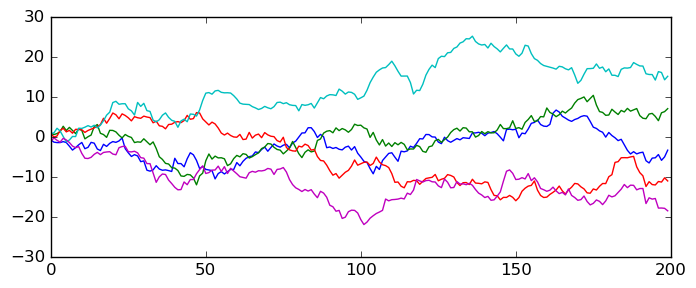

In [ ]:
horizon = 200
trajectories = [tf_runtime.trajectory(horizon) for _ in range(5)]
_, ax = plt.subplots(figsize=(8, 3))

for trajectory in trajectories:
  ax.plot(range(horizon), trajectory["rw_var"].get("state"))

We see that different simulator runs result in different random draws, hence different trajectories.

## Beyond Monte Carlo: Evaluating Log-probabilities
The example above illustrates the implementation of a simple stochastic simulation (also known as a *Monte Carlo simulation*) in RecSim NG. As discussed earlier, RecSim offers considerable additional functionality beyond simple trajectory generation. One significant difference between RecSim NG and a pure Monte Carlo simulator is that it can evaluate the probabilities of trajectories according to the DBN induced by the simulation. This functionality is contained in the ```log_probability``` module. 

The ```log_probability``` module offers a number of APIs for evaluating log probabilities of either entire trajectories, or parts thereof (e.g., individual variables or even individual fields, which is often useful when constructing various estimators). 

At the highest level, the ```log_probability_from_value_trajectory``` function takes a collection of RecSim NG simulation variables, a    ```NetworkValueTrajectory```, which provides possible values for these variables, a trajectory length (in case we want a partial evaluation), and outputs the log probability of the values in the trajectory under the variables' initial state and transition distributions.

In [ ]:
log_probs = [
    log_probability.log_probability_from_value_trajectory(
        [random_walk_var], traj, horizon - 1).numpy()
    for traj in trajectories
]
print(log_probs)

[-283.9256, -284.32123, -270.65427, -284.97693, -286.8812]


Note that the log probabilities are also differentiable with respect to parameters. For example, 

In [ ]:
with tf.GradientTape() as tape:
  log_probs = [
      log_probability.log_probability_from_value_trajectory([random_walk_var],
                                                            traj, 100)
      for traj in trajectories
  ]
  negative_likelihood = -tf.reduce_sum(log_probs)
grad = tape.gradient(negative_likelihood, normal_scale)
print(grad)

tf.Tensor(29.001118, shape=(), dtype=float32)


The above code is essentially the update step of a *stochastic gradient-based maximum likelihood estimator*. If the set of trajectories were not generated by our simulation, but instead corresponded to observations of some real-world stochastic process, this code would implement a maximum-likelihood learning algorithm to learn a model-based simulator that "explains" the data. 

Let's dig a little deeper and look under the hood of log probability computations in RecSim NG. A log probability computation is in fact a simulation in and of itself---to evaluate a log probability, RecSim NG does the following:


1.   It replaces the simulation variables with *data/replay variables*---these are variables which have the same signature as the original simulation variables, but instead of "simulating" or sampling their values, they just read their values from some data source.
2.   It then creates "*log prob*" variables. These variables are transformed versions of the simulation variables which, instead of generating a sample, employ Edward2 program transformations to compute the log probability of the replay variable's output per key, relative to the simulation variable's kernel.
3.  Finally, it creates an *aggregator variable*, which sums the outputs of the log prob variables over time and keys. 
4.   The output log probability is simply the value of the aggregator variable after *n* steps.


All of these steps are accessible to the simulation/model designer and can be customized in many different ways! For example, one can extract per-timestep, per-key disaggregated log probabilities for custom score-function estimators and the like. We illustrate this here: 



In [ ]:
# Get input data trajectory.
trajectory = trajectories[0]
rw_trajectory = trajectory["rw_var"]
# This is just a horizon x 1 tensor of values wrapped in a Value object.
# Inputs like these could come from real-world logs.
print("Trajectory shape:", rw_trajectory.get("state").shape)
# Now we create the replay variable.
replay_var = data.data_variable(
    name=random_walk_var.name + "_replay",
    spec=random_walk_var.spec,
    data_sequence=data.SlicedValue(value=trajectory[random_walk_var.name]))
# replay_var now mimics random_walk_var, except that it replays values from
# the input trajectory. For example:
print("replay_var's initial state:",
      replay_var.initial_value.fn().get("state"),
      "\n is identical to the logged trajectory at index 0:",
      trajectory["rw_var"].get("state")[0])
# Now we create the corresponding transformed log prob variable:
log_prob_var = log_probability.log_prob_variables_from_observation(
    [random_walk_var], [replay_var])
# We can have an aggregator var that sums the log probabilities over time and
# keys.
aggregators = log_probability.log_prob_accumulator_variables(log_prob_var)
# We can also have a global accumulator that adds the log probabilities of all
# variables together, but this is redundant since we have only one.
# aggregators.append(
#     log_probability.total_log_prob_accumulator_variable(log_prob_vars))
# We can now run this network
tf_runtime = runtime.TFRuntime(
    network=network_lib.Network(variables=[replay_var] + log_prob_var +
                                aggregators))
# We can either get the aggregated outputs at the last step, which is equivalent
# to the previous example:
print("Log probability of last step: ",
      tf_runtime.execute(horizon - 1)["rw_var_log_prob_accum"])
# or get the entire trajectory of log probs:
log_prob_trajectory = tf_runtime.trajectory(horizon)
print("Disaggregated log probabilities: ",
      log_prob_trajectory["rw_var_log_prob"])
# For reference, the trajectory contains the following keys:
print("Trajectory keys:", log_prob_trajectory.keys())
# corresponding to the replay var, the log probability var and the accumulator.

Trajectory shape: (200,)
replay_var's initial state: tf.Tensor(-0.58220947, shape=(), dtype=float32) 
 is identical to the logged trajectory at index 0: tf.Tensor(-0.58220947, shape=(), dtype=float32)
Log probability of last step:  Value[{'state': <tf.Tensor: shape=(), dtype=float32, numpy=-283.9256>}]
Disaggregated log probabilities:  Value[{'state': <tf.Tensor: shape=(200,), dtype=float32, numpy=
array([-1.0884224 , -1.0893903 , -0.9264586 , -0.91894114, -0.9491419 ,
       -0.94670796, -1.3360205 , -1.3899759 , -1.1114663 , -1.168746  ,
       -1.0847802 , -2.1293712 , -0.97579426, -1.6905679 , -0.9380691 ,
       -1.9812022 , -0.99771154, -2.1495352 , -1.0598828 , -1.2094593 ,
       -1.0197289 , -0.93745774, -0.9812193 , -1.1953458 , -4.492368  ,
       -1.4562724 , -1.3406684 , -1.0203346 , -0.96815187, -1.9457467 ,
       -0.937134  , -3.6148767 , -0.9463751 , -0.9658838 , -1.4671748 ,
       -1.2601641 , -0.96707296, -0.9233948 , -0.9349471 , -0.94283074,
       -6.353716  , -1

One particular shortcut is worth pointing out. The above API computes log probabilities no matter where the trajectories come from (e.g., from logs, or from a different simulation model). However, if we are specifically interested in computing log probabilities relative to the model being simulated, we can insert log prob variables directly to the simulation itself by using the ```log_prob_variables_from_direct_output``` function instead of first generating the trajectories and then evaluating their log probabilities. This comes in handy , for example, in reinforcement learning applications, where we simulate a run of an agent in some environment, and use its action log probabilities to compute policy gradients. Here is an example of this:

In [ ]:
def rw_next(previous_state: Value) -> Value:
  return Value(state=ed.Normal(loc=previous_state.get("state"), scale=1.0))


random_walk_var = Variable(name="rw_var", spec=ValueSpec(state=FieldSpec()))
random_walk_var.initial_value = variable.value(
    lambda: Value(state=ed.Normal(loc=0.0, scale=1.0)))
random_walk_var.value = variable.value(rw_next, (random_walk_var.previous,))
rw_log_prob = log_probability.log_prob_variables_from_direct_output(
    [random_walk_var])[0]
tf_runtime = runtime.TFRuntime(
    network=network_lib.Network([random_walk_var, rw_log_prob]))
trajectory = tf_runtime.trajectory(2)
print("Simulated random walk: ", trajectory["rw_var"])
print("Log probabilities: ", trajectory["rw_var_log_prob"])

Simulated random walk:  Value[{'state': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.18111575, -1.5586151 ], dtype=float32)>}]
Log probabilities:  Value[{'state': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.93534  , -1.8676908], dtype=float32)>}]


This runtime simultaneously simulates the random walk and computes the log probabilities of every state transition.

## A Few Gotchas
Before we move on with an application, let's discuss some potential issues that come up when computing log probabilities. Writing simulation code in which log probabilities can be evaluated using RecSim NG's APIs involves a few special considerations.

The first thing to keep in mind is that RecSim NG does not allow "latent variables" in the following sense:  every random variable must be observable ***to the simulator***. This does *not* mean  that random variables cannot be latent from the point of view of different *agents* in the simulation (e.g., a recommender agent may not be able to observe the true, latent preferences of a user when making a recommendation)---it simply means that the *simulator itself* must be able to observe everything. What this means in practice is that:
1. All randomness must be sources from Edward2 random variables; and
1. Every Edward2 random variable must be bound to some key of a RecSim NG variable.

Both are necessary for the simulator to be able to map the observed data to the actual random draws that are intended to explain that data. We provide two counter-examples to illustrate what can go wrong if these conditions are not met.




In [ ]:
def rw_next(previous_state: Value) -> Value:
  return Value(
      state=tf.random.normal([1], previous_state.get("state"), 1.0, tf.float32))


random_walk_var = Variable(name="rw_var", spec=ValueSpec(state=FieldSpec()))
random_walk_var.initial_value = variable.value(
    lambda: Value(state=tf.random.normal([1], 0.0, 1.0, tf.float32)))
random_walk_var.value = variable.value(rw_next, (random_walk_var.previous,))

tf_runtime = runtime.TFRuntime(network=network_lib.Network([random_walk_var]))

This code violates (1) in that it does not use Edward2 for randomness (calls tf.random.normal). We see that Monte Carlo simulations still work and trajectories are sampled from the same distribution as the original:

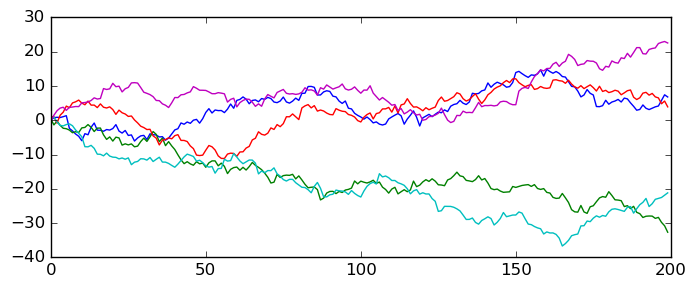

In [ ]:
trajectories = [tf_runtime.trajectory(horizon) for _ in range(5)]
_, ax = plt.subplots(figsize=(8, 3))

for trajectory in trajectories:
  ax.plot(range(horizon), trajectory["rw_var"].get("state"))

Unfortunately, log probability evaluation is incorrect, as the simulator does not see the random draws as being random:

In [ ]:
log_probs = [
    log_probability.log_probability_from_value_trajectory(
        [random_walk_var], traj, horizon - 1).numpy()
    for traj in trajectories
]
print(log_probs)

[0.0, 0.0, 0.0, 0.0, 0.0]


Here is a snippet that illustrates a violation of condition (2).

In [ ]:
def rw_next(previous_state: Value) -> Value:
  return Value(
      state=previous_state.get("state") + ed.Normal(loc=0.0, scale=1.0))


random_walk_var = Variable(name="rw_var", spec=ValueSpec(state=FieldSpec()))
random_walk_var.initial_value = variable.value(
    lambda: Value(state=0.0 + ed.Normal(loc=0.0, scale=1.0)))
random_walk_var.value = variable.value(rw_next, (random_walk_var.previous,))

tf_runtime = runtime.TFRuntime(network=network_lib.Network([random_walk_var]))

This code is again identical in the Monte Carlo sense. However, what is returned are TensorFlow scalars due to the final addition operator and not Edward2 random variables, so the simulator cannot associate the data with the random draws. This will generate an error stating that some random variable is not being returned.

In [ ]:
trajectories = [tf_runtime.trajectory(horizon) for _ in range(5)]
try: 
  log_probs = [
      log_probability.log_probability_from_value_trajectory(
          [random_walk_var], traj, horizon - 1).numpy()
      for traj in trajectories
  ]
except Exception as e:
  print(e)




---


The second significant source of errors stems from the fact that RecSim NG variables are *not allowed to change shape across time steps*. This requirement may seem straightforward, but ends up having some interesting implications on the way in which variables should be sampled to ensure their log probabilities can be properly evaluated.

One somewhat subtle source of confusion arises from the notion of shapes used by TensorFlow Probability (TFP). TFP uses the notions of *event shape*, *batch shape*, and *sample shape*. The event shape is the tensor shape of the random variable being sampled. The batch shape is used to pack independent, but not identical, draws of distributions from the same family into a tensor, while the sample shape is used to pack independent and identical draws. These shapes determine the shape of the log probability tensor computed by the TFP distribution, respectively, the Edward2 random variable. 

The significance of this in the context of simulation is that we may accidentally implement simulations which run as intended in the Monte Carlo regime, but cause shape-change issues during log probability computation.

Here is a quick illustration. Suppose we wish to sample two values from a standard normal distribution. In principle, we could use any of the following three ways to generate these samples, drawing from:
1. a standard normal with sample shape (2,), 
1. a batch of two standard normals, and 
1. a bivariate normal with zero mean and unit covariance.

When evaluating the log probabilities under (1) and (2), we get a 2x1 tensor of log probs, but (3) will return a single scalar:

In [ ]:
sample = tf.random.normal(shape=[2], mean=0.0, stddev=1.0)
indep_sample_rv = ed.Normal(loc=0.0, scale=1.0, sample_shape=[2])
print("Log prob with sample shape [2]:",
      indep_sample_rv.distribution.log_prob(sample))
batch_sample_rv = ed.Normal(loc=[0.0, 0.0], scale=[1.0, 1.0])
print("Log prob with batch shape [2]:",
      batch_sample_rv.distribution.log_prob(sample))
event_sample_rv = ed.MultivariateNormalDiag(
    loc=[0.0, 0.0], scale_identity_multiplier=1.0)
print("Log prob with event shape [2]:",
      event_sample_rv.distribution.log_prob(sample))

Log prob with sample shape [2]: tf.Tensor([-0.91893864 -3.3121057 ], shape=(2,), dtype=float32)
Log prob with batch shape [2]: tf.Tensor([-0.91893864 -3.3121057 ], shape=(2,), dtype=float32)
Log prob with event shape [2]: tf.Tensor(-4.2310443, shape=(), dtype=float32)


This is again a situation where these different samplers are identical in the Monte Carlo sense, but sample from "semantically" different distributions. 

This can easily leads to errors in simulations by causing a log-prob shape mismatch between the initial and next state distributions:

In [ ]:
def rw_next(previous_state: Value) -> Value:
  # Next state samples from a batch of two normals.
  return Value(state=ed.Normal(loc=previous_state.get("state"), scale=1.0))


random_walk_var = Variable(name="rw_var", spec=ValueSpec(state=FieldSpec()))
# Initial state samples from a multivariate normal.
random_walk_var.initial_value = variable.value(lambda: Value(
    state=ed.MultivariateNormalDiag(
        loc=[0.0, 0.0], scale_identity_multiplier=1.0)))
random_walk_var.value = variable.value(rw_next, (random_walk_var.previous,))

tf_runtime = runtime.TFRuntime(network=network_lib.Network([random_walk_var]))

This model is fine for sampling, but evaluating log probs will lead to an exception:

In [ ]:
trajectories = [tf_runtime.trajectory(horizon) for _ in range(5)]
try: 
  log_probs = [
      log_probability.log_probability_from_value_trajectory(
          [random_walk_var], traj, horizon - 1).numpy()

      for traj in trajectories
  ]
except Exception as e:
  print(e)

This error shows the RecSim NG typechecking system informing us that a field changed shape across iterations. 

With these precautions in mind, we now illustrate how these ideas come together in larger recommender-system applications.

# Putting It All Together: User Model Learning

In this section, we showcase how the uncertainty APIs of RecSim NG can be used within a recommender-system model-learning application. In this scenario, we envision a number of users repeatedly interacting with a recommender. Each interaction proceeds as follows: the recommender serves a slate (small set) of recommended items to each user; each user examines their slate and responds to it in some way (e.g., by clicking, rating or consuming an item in the case of content); each user then updates their own (latent) state; finally, the recommender observes each user's responses.

The RecSim NG tasks we consider focus on the inference of the parameters of the *user model*, comprising models which specify their choice/response behaviors and how they update their state. We assume there is a "ground truth" user model with specific parameter values, which is used to generate trajectories. These trajectories will be used to fit a second instantiation of the user model---think of this as the model of user behavior a recommender system might build to optimize its performance---with the same structure, but with unknown parameter values. We consider two flavors of problem: the easy case is where the trajectory data contains all simulation variables, including those that model "mental processes" of the user; and the more involved, but more realistic, case in which some random variables are not made available in the trajectories. The latter case reflects the situation faced by most recommender systems, which cannot directly observe a user's latent state (e.g., her interests, level of satisfaction, etc.).

For simplicity of presentation, we hardcode some parameter values directly into the model. A version of this example can also be found at ```recsim_ng.applications.latent_variable_model_learning```, where most parameter values are configurable.

## The User Model

In our simulated world, we assume that each recommendable item can be represented in a 2-dimensional Euclidean space. 
A user has a *state* consisting of:
* an *intent* realized by a target item: we assume the user has some goal in mind, expressible as an "ideal" point within the same space in which the items are embedded. The intent induces a preference model according to which items closer to the user's intent are preferred to those which are further away.
* a dynamic *satisfaction* variable $s$, which reflects the user's (personal or subjective) assessment of whether the recommender makes progress towards the target.

When presented with a slate of recommended items, the user's *choice process* either selects an item for consumption, using the sum of item affinities (computed as the negative Euclidean distance between the item and the intent) and satisfaction as logits, or abstain according to a constant "no choice" logit (which we set to 0 for simplicity). The user's satisfaction acts as a boost to the item-level logits compared to the constant "no choice" logit; thus, at high levels of satisfaction, the user is more likely to select some item for consumption. If the user's satisfaction drops and no good items are found, the user effectively "drops out" of the system (i.e., the probability of choosing anything other than "no choice" becomes negligible).

The user state updates as follows:
* The intent is sampled from a mixture model with component means $[1.0, 0.0]^T, [0.0, 1.0]^T$. This distribution over intents remains fixed over time.
* Satisfaction $s$ evolves as: $$s_t = \mathrm{satisfaction\ sensitivity} \cdot s_{t-1} + \delta_t + \epsilon,$$ where: satisfaction sensitivity is a parameter (set to 0.8 in this case); $\delta_t$ is the difference between the maximum affinity among the items from the slate presented at time $t$ and the maximum of the  time $(t-1)$ slate; and $\epsilon$ is zero-mean Gaussian noise with standard deviation of $0.1$.

This model is implemented below using intent, choice, and affinity model implementations provided by the RecSim NG library.



In [ ]:
# @title RecSimNG modeling imports. 
from recsim_ng.stories import recommendation_simulation as simulation
from recsim_ng.applications.latent_variable_model_learning import recommender
from recsim_ng.entities.recommendation import user
from recsim_ng.entities.state_models import static
from recsim_ng.entities.choice_models import selectors
from recsim_ng.entities.choice_models import affinities

In [ ]:
class ModelLearningDemoUser(user.User):

  def __init__(self,
               config: Mapping[Text, Any],
               satisfaction_sensitivity: tf.Tensor,
               name: Text = 'ModelLearningDemoUser') -> None:
    super().__init__(config, name)
    self._slate_size = config.get('slate_size')
    # Hardcoded parameter values.
    self._user_intent_variance = 0.1
    self._initial_satisfication = 5.0
    # Unknown satisfaction sensitivity.
    self._sat_sensitivity = satisfaction_sensitivity
    # The intent model as a GMM state model from the RecSim NG state
    # model library.
    batch_intent_means = tf.eye(
        2, num_columns=2, batch_shape=(self._num_users,))
    lop_ctor = lambda params: tf.linalg.LinearOperatorScaledIdentity(
        num_rows=2, multiplier=params)
    self._intent_model = static.GMMVector(
        batch_ndims=1,
        mixture_logits=tf.zeros((self._num_users, 2)),
        component_means=batch_intent_means,
        component_scales=tf.sqrt(self._user_intent_variance),
        linear_operator_ctor=lop_ctor)
    # The choice model is a multinomial logit choice model from the RecSim NG
    # choice model library.
    self._choice_model = selectors.MultinomialLogitChoiceModel(
        batch_shape=(self._num_users,),
        nochoice_logits=tf.ones(self._num_users))
    # The affinity model is a target point similarity model, which by default
    # computes the negative Euclidean distance between the target point and the
    # item embedding.
    self._affinity_model = affinities.TargetPointSimilarity(
        batch_shape=(self._num_users,), slate_size=self._slate_size)

  def initial_state(self) -> Value:
    """Initial state value."""
    return Value(
        satisfaction=ed.Deterministic(self._initial_satisfication *
                                      tf.ones(self._num_users)),
        intent=self._intent_model.initial_state().get('state'),
        max_slate_utility=tf.zeros(self._num_users))

  def next_state(self, previous_state: Value, _, slate_docs: Value) -> Value:
    """State transition kernel."""
    # Compute the improvement of slate scores.
    slate_doc_features = slate_docs.get('features')
    slate_doc_affinities = self._affinity_model.affinities(
        previous_state.get('intent'), slate_doc_features).get('affinities')
    max_slate_utility = tf.reduce_max(slate_doc_affinities, axis=-1)
    improvement = max_slate_utility - previous_state.get('max_slate_utility')
    next_satisfaction = self._sat_sensitivity * previous_state.get(
        'satisfaction') + improvement
    return Value(
        satisfaction=ed.Normal(loc=next_satisfaction, scale=0.01),
        intent=self._intent_model.next_state(
            Value(state=previous_state.get('intent'))).get('state'),
        max_slate_utility=max_slate_utility)

  def next_response(self, previous_state: Value, slate_docs: Value) -> Value:
    """The response value after the initial value."""
    slate_doc_features = slate_docs.get('features')
    slate_doc_scores = self._affinity_model.affinities(
        previous_state.get('intent'), slate_doc_features).get('affinities')
    # Adding the user's satisfaction to the item scores.
    adjusted_scores = (
        slate_doc_scores + previous_state.get('satisfaction')[..., tf.newaxis])
    return self._choice_model.choice(adjusted_scores)

  def observation(self):
    pass

  def specs(self) -> ValueSpec:
    response_spec = self._choice_model.specs()
    state_spec = ValueSpec(
        intent=self._intent_model.specs().get('state'),
        satisfaction=FieldSpec(),
        max_slate_utility=FieldSpec())
    return state_spec.prefixed_with('state').union(
        response_spec.prefixed_with('response'))


With this user model, we can now set up the *ground-truth* simulation and generate some ground-truth trajectories.

In [ ]:
# Initialize simulation parameters
gt_satisfaction_sensitivity = 0.8 * tf.ones(5)
num_users = 5
num_topics = 2
horizon = 6

config = {
    "slate_size": 2,
    "num_users": num_users,
    "num_topics": num_topics,
    "num_docs": 0
}
# Set up ground truth runtime.
gt_user_ctor = functools.partial(
      ModelLearningDemoUser,
      satisfaction_sensitivity=gt_satisfaction_sensitivity)
gt_variables = simulation.simplified_recs_story(config, gt_user_ctor,
                                          recommender.SimpleNormalRecommender)
gt_network = network_lib.Network(variables=gt_variables)
gt_runtime = runtime.TFRuntime(network=gt_network)
traj = dict(gt_runtime.trajectory(length=horizon))
print('===============GROUND TRUTH LIKELIHOOD================')
print(
    log_probability.log_probability_from_value_trajectory(
        variables=gt_variables, value_trajectory=traj, num_steps=horizon - 1))
print('======================================================')

===============GROUND TRUTH LIKELIHOOD================
tf.Tensor(-38.463882, shape=(), dtype=float32)


We will also set up a parallel copy of the simulation in which the satisfaction sensitivity is *a priori* unknown and randomly initialized. We'll also evaluate the log probability of the ground-truth trajectories from the original simulator under the untrained model.

In [ ]:
trainable_sat_sensitivity = tf.Variable(
    tf.math.sigmoid(ed.Normal(loc=tf.zeros(5), scale=1.0)))
trainable_user_ctor = functools.partial(
    ModelLearningDemoUser, satisfaction_sensitivity=trainable_sat_sensitivity)
t_variables = simulation.simplified_recs_story(
    config, trainable_user_ctor, recommender.SimpleNormalRecommender)
trainable_network = network_lib.Network(variables=t_variables)
trainable_runtime = runtime.TFRuntime(network=trainable_network)
print('===============UNTRAINED LIKELIHOOD================')
print(
    log_probability.log_probability_from_value_trajectory(
        variables=t_variables, value_trajectory=traj, num_steps=horizon - 1))
print('======================================================')

===============UNTRAINED LIKELIHOOD================
tf.Tensor(-223204.06, shape=(), dtype=float32)


As we can see, not surprisingly, the ground-truth trajectories are multiple (log-) orders of magnitude less plausible under the untrained model than they are under the ground-truth model. To calibrate (or train) the untrained model, we use the following procedure:
1. We sample a set of trajectories from the ground-truth model.
2.  We adjust the satisfaction sensitivity parameter in the trained model in the direction that increases the likelihood of the ground-truth trajectories. 

This is a stochastic version of gradient-based maximum likelihood training. If the likelihood function is well-enough behaved, we can hope that this process will converge to the ground-truth parameters or some other set of parameters that performs equally well. The following code snippet implements the maximum likelihood training loop:

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function
def training_step():
  with tf.GradientTape() as tape:
    gt_trajectory = gt_runtime.trajectory(length=horizon)
    neg_likelihood = -log_probability.log_probability_from_value_trajectory(
        variables=t_variables, value_trajectory=traj, num_steps=horizon - 1)
  grads = tape.gradient(neg_likelihood, [trainable_sat_sensitivity])
  optimizer.apply_gradients(zip(grads, [trainable_sat_sensitivity]))
  return neg_likelihood

likelihood_history = []
print(f"Parameters before training: {trainable_sat_sensitivity.numpy()}")
for i in range(101):
  obj = training_step()
  likelihood_history.append(-obj)
  if not i % 20:
    print(f"Iteration {i}, negative likelihood {obj.numpy()}")
    print(f"Parameter values: {trainable_sat_sensitivity.numpy()}")

Parameters before training: [0.48540968 0.37344843 0.5908341  0.3959334  0.12628874]
Iteration 0, negative likelihood 223204.0625
Parameter values: [0.49540967 0.38344842 0.6008341  0.40593338 0.13628875]
Iteration 20, negative likelihood 83791.0234375
Parameter values: [0.6824743 0.5748696 0.776621  0.5967244 0.3314404]
Iteration 40, negative likelihood 26727.419921875
Parameter values: [0.7964278  0.71955895 0.82324153 0.73694897 0.50187737]
Iteration 60, negative likelihood 7806.90234375
Parameter values: [0.81591403 0.7914579  0.7965654  0.799916   0.63205963]
Iteration 80, negative likelihood 1937.3466796875
Parameter values: [0.80240583 0.8072632  0.79837674 0.808281   0.7184297 ]
Iteration 100, negative likelihood 365.5766906738281
Parameter values: [0.7987236  0.80294615 0.80081785 0.80180526 0.7673559 ]


Running the training loops for a couple of iterations shows a nice improvement in likelihood as visualized below. From the printouts, we can also see that the parameters converge to their ground truth values.

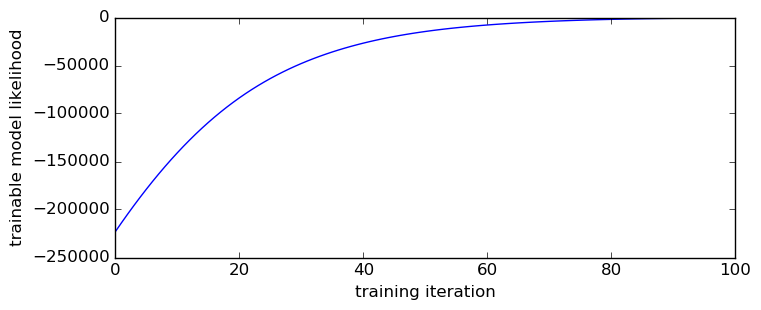

In [ ]:
_, ax = plt.subplots(figsize=(8, 3))
ax.plot(range(len(likelihood_history)), likelihood_history)
plt.xlabel('training iteration')
plt.ylabel('trainable model likelihood')
plt.show()

## Partially observed data.

Model learning problems like the one above, where all random variables are observed in every trajectory, are relatively straightforward to solve (at least conceptually). However, in many real-world applications, especially those concerning recommender systems, we cannot expect to observe everything that goes on in the domain of interest. This is true almost by definition in the realm of *user modeling*, where the tools needed to understand users' behaviors tend to be psychometric constructs, such as preferences, interests, personality characteristics, mood/sentiment, and so on. These are hypothesized to "exist" only in the user's mind and can only be inferred via the observed behaviors which they influence. Other unobservable characteristics involving the user's context or environment may also influence their behavior in a recommendation setting (e.g., context variables like the user's location, their activity, and their companions).

Learning simulators from partially observed data is still possible, though not as straightforward as in the fully observed case. 

There are several well-understood ways to train a latent variable model for use as a simulator. For the purposes of this tutorial, we implement a classical technique called *Expectation-Maximization (EM)*. 

Let $X$ be the set of observed variables, $Y$ be the set of unobserved variables, and $\theta$ be the set of model parameters. In the fully observed case ($Y = \emptyset$), one natural approach is to find parameters that maximize the plausibility of the observed data $X$ by maximizing the log-likelihood:
$$\theta^\ast = \arg\max_\theta \log p_\theta(X).$$

 The starting point of EM is to extend the idea of maximizing log-marginal likelihood of $X$ by integrating out $Y$:
 $$\theta^* = \arg\max_\theta \log \int_Y p_\theta(X,Y).$$
Algorithmically, this is done by constructing a sequence of lower bounds
$$ f(\theta; \theta_k) = \int_Y p_{\theta^k}(Y|X)\log p_\theta(X,Y) + H_{\theta^k} \leq \log \int_Y p_\theta(X,Y),$$
where $\theta^k$ is the parameter guess at step $k$, and $H_{\theta^k}$ is a quantity dependent on $\theta_k$, which can be ignored for our particular purposes. 

A "vanilla" EM iteration (e.g., step $k+1$) typically proceeds in two phases:
1. Compute $f(\theta; \theta_k)$ (E-step).
2. Update parameters as $\theta_{k+1} = \arg\max_\theta f(\theta; \theta_k)$ (M-step).

There are two challenges to address before we can put this into action: first, we need a tractable way of computing (possibly approximating) the posterior expectation over $Y|X$ in the E-step. Second, we need to be able to compute (again, approximate) the argmax parameters in the M-step. 

The first challenge will be addressed using *posterior sampling*. Specifically, we replace the expectation $\int_Y p_{\theta^k}(Y|X)\log p_\theta(X,Y)$ by a Monte-Carlo estimate $\frac{1}{|S|}\sum_{s\in S} \log p_\theta(X,Y_s)$, where $\{Y_1,\ldots, Y_s\}$ are samples from the posterior distribution $p(\cdot|X)$. The second challenge is addressed using gradient ascent on $\theta$. In fact, we just replace step 2 by a *single* gradient step instead of running gradient descent to convergence every time (this works fine in our case---surprise, surprise---but, in general, how much and what type of maximization is realized in step 2 may change the convergence properties of the algorithm).

We already know how to perform gradient ascent on parameter likelihoods, so what remains to show is how to implement posterior sampling with RecSim NG.

In [ ]:
# Reinitialize trainable variables.
trainable_sat_sensitivity.assign(
    tf.math.sigmoid(ed.Normal(loc=tf.zeros(5), scale=1.0)))

<tf.Variable 'UnreadVariable' shape=(5,) dtype=float32, numpy=
array([0.85395336, 0.62427443, 0.82974935, 0.5824438 , 0.59435993],
      dtype=float32)>

Our posterior sampling implementation uses a *Markov-Chain Monte Carlo (MCMC)* sampler provided by TFP. MCMC is a family of algorithms for sampling from an unnormalized density---such methods start at some point in the support of the density and incrementally perturb that point using information from the density. We use the *Hamiltonian Monte Carlo (HMC)* approach, which stochastically moves the sample in the direction of the gradient of the log probability function. TFP already offers a robust implementation of HMC, so our job is only to provide its inputs.

To illustrate latent variable model learning, let's assume that every user's intent is an *unobserved* variable, while all other parts of the trajectory are given. To use TFP's HMC implementation, we need to implement the unnormalized (log) density $\phi(Y) := \log p(X,Y)$, where $Y$ is the array consisting of the users' intents. Moreover, $\phi(Y)$ must be differentiable with respect to $Y$. This is relatively straightforward in RecSim NG. Since the user intent doesn't change over time, we can recreate the intent trajectory by expanding the intent vector over time. Then, we combine that intent trajectory with the observed data and call the log prob function. The implementation is given below.

In [ ]:
@tf.function
def unnormalized_log_prob_train(intent: tf.Tensor) -> tf.Tensor:
  # Expand initial intent to complete intent trajectory.
  intent_traj = tf.expand_dims(
      intent, axis=0) + tf.zeros((horizon, num_users, num_topics))
  # Combine intent trajectory with the observed data.
  user_state_dict = dict(traj['user state'].as_dict)
  user_state_dict['intent'] = intent_traj
  traj['user state'] = Value(**user_state_dict)
  # Return the log probability of the imputed intent + observations.
  return log_probability.log_probability_from_value_trajectory(
      variables=t_variables, value_trajectory=traj, num_steps=horizon - 1)

With the unnormalized density implementation, setting up the HMC sampler follows the TFP [HamiltonianMonteCarlo example code](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/HamiltonianMonteCarlo) almost verbatim.

In [ ]:
num_results = int(2e3)
num_burnin_steps = int(5e2)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob_train,
        num_leapfrog_steps=5,
        step_size=.00008),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# Run the chain (with burn-in).
@tf.function
def run_chain():
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=tfd.Normal(loc=tf.ones((5, 2)) / 5, scale=0.5).sample(),
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

  sample_mean = tf.reduce_mean(samples)
  sample_stddev = tf.math.reduce_std(samples)
  is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
  return samples, sample_mean, sample_stddev, is_accepted

We now implement our training loop, which imputes the latent user intents and then computes the likelihood gradients of the model parameters (please note: running this may take some time):

In [ ]:
#@test {"skip": true}
# Initialize the HMC transition kernel.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
elbo_history = []
for i in range(101):
  posterior_samples, sample_mean, sample_stddev, is_accepted = run_chain()
  log_probs = []
  with tf.GradientTape() as tape:
    log_probs = tf.vectorized_map(unnormalized_log_prob_train,
                                  posterior_samples[num_burnin_steps:,])
    neg_elbo = -tf.reduce_mean(log_probs)
  grads = tape.gradient(neg_elbo, [trainable_sat_sensitivity])
  optimizer.apply_gradients(zip(grads, [trainable_sat_sensitivity]))
  elbo_history.append(-neg_elbo)
  if not i % 5:
    print(f"Iteration {i}, unnormalized negative ELBO {neg_elbo.numpy()}")
    print(f"Parameter values: {trainable_sat_sensitivity.numpy()}")
    print(f"Acceptance rate: {is_accepted.numpy()}")

Iteration 0, unnormalized negative ELBO 10907.8486328125
Parameter values: [0.8439534  0.6342744  0.81974936 0.59244376 0.6043599 ]
Acceptance rate: 0.6629999876022339
Iteration 5, unnormalized negative ELBO 3477.6552734375
Parameter values: [0.84924823 0.6806311  0.79297256 0.6338071  0.6531151 ]
Acceptance rate: 0.8705000281333923
Iteration 10, unnormalized negative ELBO 3598.144775390625
Parameter values: [0.8455839  0.72616017 0.7912083  0.66730124 0.69621223]
Acceptance rate: 0.8880000114440918
Iteration 15, unnormalized negative ELBO 2717.02294921875
Parameter values: [0.8568001  0.7666226  0.8023705  0.7004531  0.73060715]
Acceptance rate: 0.8995000123977661
Iteration 20, unnormalized negative ELBO 1063.31103515625
Parameter values: [0.8587995  0.79394627 0.80976456 0.7290326  0.7561469 ]
Acceptance rate: 0.8774999976158142
Iteration 25, unnormalized negative ELBO 2830.359375
Parameter values: [0.84353304 0.809964   0.80888164 0.75223213 0.76822114]
Acceptance rate: 0.8665000200

We see that the ground truth parameters are recovered more or less successfully. The following figure plots the progress of the objective function. As we mention that we only have one gradient step for the M-step, the objective value can oscillate with high variance.


Text(0, 0.5, 'ELBO')

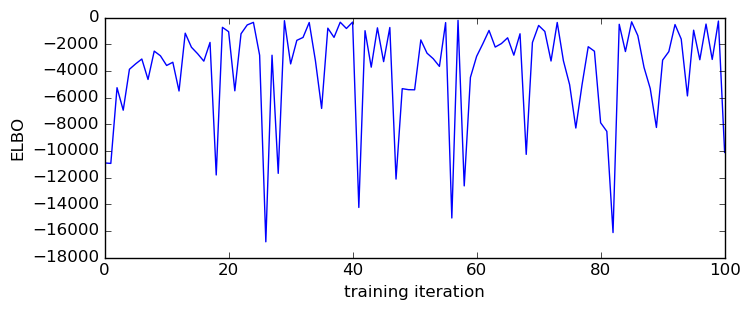

In [ ]:
#@test {"skip": true}
_, ax = plt.subplots(figsize=(8, 3))
ax.plot(range(len(elbo_history)), elbo_history)
plt.xlabel('training iteration')
plt.ylabel('ELBO')